<a href="https://colab.research.google.com/github/nowakdoma/ComputerVision_PUT/blob/main/2_Workbook_operacje_morfologiczne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Widzenie komputerowe
# Moduł laboratoryjny 3, Laboratoria 5 i 6

## Opis laboratoriów



*   Wprowadzenie do operacji morfologicznych,
*   Operacje morfologiczne dla obrazów binarnych,
*   Operacje morfologiczne dla obrazów ze skalą intensywności,
*   Morfologia jako narzędzie do segmentacji



## Funkcje pomocnicze

Do wykonania zadań niezbędne jest zaimportowanie bibliotek, wykorzystywanych w skrypcie oraz pobranie danych, na których przetwarzane będą operacje.

W skrypcie wykorzystywane będą dwa zestawy danych:
* obraz Lenna (dostępny pod [linkiem](http://www.lenna.org/)) - jeden z najbardziej popularnych obrazów wykorzystywanych historycznie do kompresji i przetwarzania obrazów,
* Zdjęcie supernowy - zdjęcie kosmicznej eksplozji (dostępny pod [linkiem](https://upload.wikimedia.org/wikipedia/commons/b/bd/G299-Remnants-SuperNova-Type1a-20150218.jpg))

In [ ]:
# import niezbędnych bibliotek
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
%matplotlib inline
from pandas import DataFrame
import pandas as pd
from IPython.display import display, HTML
from skimage.exposure import rescale_intensity
import plotly.graph_objects as go
import pandas as pd
import json
import os

pd.options.display.html.border = 0
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
# pobranie niezbędnych bibliotek
!wget -O lena_std.tif http://www.lenna.org/lena_std.tif
!wget -O supernova.jpg https://upload.wikimedia.org/wikipedia/commons/b/bd/G299-Remnants-SuperNova-Type1a-20150218.jpg

--2025-04-08 21:48:22--  http://www.lenna.org/lena_std.tif
Resolving www.lenna.org (www.lenna.org)... 107.180.37.106
Connecting to www.lenna.org (www.lenna.org)|107.180.37.106|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 786572 (768K) [image/tiff]
Saving to: ‘lena_std.tif’

lena_std.tif        100%[===================>] 768.14K  2.38MB/s    in 0.3s    

2025-04-08 21:48:23 (2.38 MB/s) - ‘lena_std.tif’ saved [786572/786572]

--2025-04-08 21:48:23--  https://upload.wikimedia.org/wikipedia/commons/b/bd/G299-Remnants-SuperNova-Type1a-20150218.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186301 (182K) [image/jpeg]
Saving to: ‘supernova.jpg’

supernova.jpg       100%[===================>] 181.93K  --.-KB/s    in 0.09s   

2025-04-08 21:48:23 (2.04 MB/s) - ‘supernova.j

Ze względu na problem z wyświetlaniem obrazów przez bibliotekę OpenCV w środowisku Colab, w przypadku korzystania z tej platformy należy skorzystać z funkcji specjalnie do tego przygotowanej.

In [ ]:
def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

In [ ]:
def h_color(a, interpolation=None, size=None, fy=1.5, fx=1.5, cmap='gray'):
  s = [int(a.shape[0] * fy), int(a.shape[1] * fx)] if size is None else size
  plt.figure(figsize=s)
  plt.tick_params(
    axis='both', which='both',
    bottom=False, top=False,
    labelbottom=False, labelleft=False, left=False, right=False
  )
  plt.imshow(a, cmap=cmap, interpolation=interpolation)

In [ ]:
css = """
<style type="text/css">
  table, td, table.dataframe, table.dataframe td {
    border: 1px solid black;    //border: double;
    border-collapse: collapse;
    border-style: solid;
    border-spacing: 0px;
    background-color: rgb(250,250,250);
    width: 24px;
    height: 24px;
    text-align: center;
    transform: scale(1.0);
    margin: 5px;
    }
</style>
"""

def h(s):
   return display(HTML(css + DataFrame(s).to_html(header=False, index=False)))

In [ ]:
def h_color_3d(z):
  fig = go.Figure(data=[go.Surface(z=z)])
  fig.update_layout(autosize=False, width=500, height=500)
  fig.show()

# Operacje morfologiczne


Operacja morfologiczna to technika przetwarzania obrazu binarnego, która modyfikuje obraz wejściowy w arbitralny sposób (np. zapalając lub gasząc bit piksela) na podstawie **dopasowania** otoczenia danego piksela z **elementem strukturalnym**.

Powyższa definicja operacji morfologicznej wymusza wytłumaczenie pewnych terminów:
* element strukturalny - maska bitowa, określająca strukturę, którą szukamy na obrazie. Nawiązując do operacji konwolucji, jest to odpowiednik dopasowywanej funkcji do obrazu wejściowego (np. laplasjan, pochodna),
* dopasowanie - zgodność elementu strukturalnego z wybranym pikselem oraz jego sąsiedztwem, wymiarowo odpowiadającym elementowi strukturalnemu. Może być reprezentowana jako maska bitowa o rozmiarze elementu strukturalnego,
* operacja morfologiczna przypomina konwolucję - również pewna funkcja jest dopasowywana do obrazu wejściowego, jednak aby wykonać modyfikację danego piksela muszą zostać spełnione pewne warunki zgodności,

Różne warunki zgodności definiują następujące operacje:
* erozja - jeśli **wszystkie zapalone** składowe elementu strukturalnego i odpowiadające im składowe otoczenia danego piksela są takie same, piksel jest zapalany. W przeciwnym wypadku gaszony. Inaczej: dopasowanie zawiera same **1**.
* dylatacja - jeśli **dowolna zapalona** składowa elementu strukturalnego i odpowiadająca mu składowa otoczenia danego piksela są takie same, piksel jest zapalany. W przeciwnym wypadku gaszony. Inaczej: dopasowanie zawiera choć jedno **1**.
* otwarcie - dylatacja poprzedzona erozją, (dylatacja(erozja(obraz))
* zamknięcie - erozja poprzedzona dylatacją, (erozja(dylatacja(obraz))


## Obraz binarny

Zdefiniujmy przykładowy obraz binarny oraz prosty element strukturalny o rozmiarze (2,2) wypełniony zapalonymi bitami.

Element strukturalny:


1,1
1,1


Obraz wejściowy:


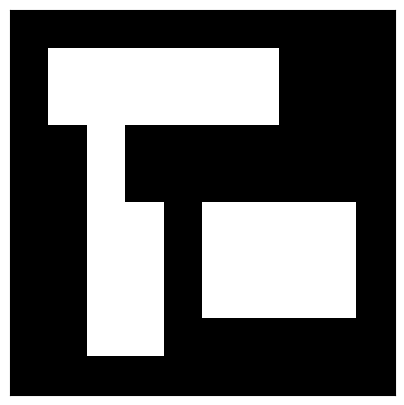

In [ ]:
img_bin = np.zeros((10, 10), np.uint8)
img_bin[1:3, 1:7] = 1
img_bin[5:9, 2:4] = 1
img_bin[5:8, 5:9] = 1
img_bin[3:5, 2] = 1

struct = np.ones((2, 2),np.uint8)

print('Element strukturalny:')
h(struct)

print('Obraz wejściowy:')
h_color(img_bin, fx=0.5, fy=0.5)

### Erozja i Dylatacja

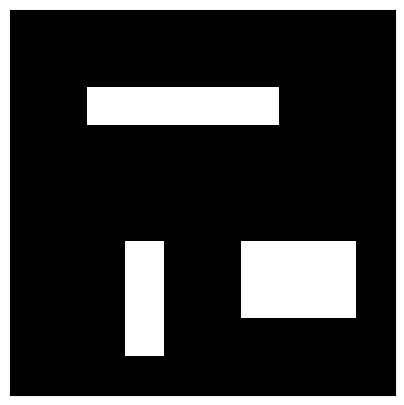

In [ ]:
img_bin_ero = cv2.erode(img_bin, struct, iterations=1)
h_color(img_bin_ero, fx=0.5, fy=0.5)

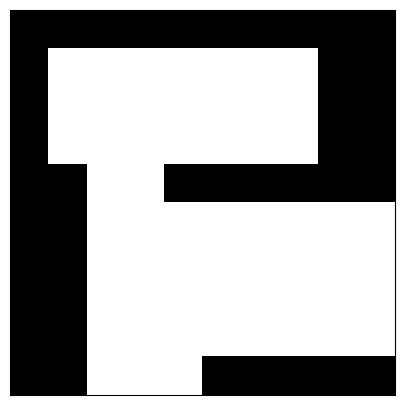

In [ ]:
img_bin_dil = cv2.dilate(img_bin, struct, iterations=1)
h_color(img_bin_dil, fx=0.5, fy=0.5)

#### Zadanie 1

Zaimplementuj operację erozji i dylatacji:

Dopasowanie odpowiedającym sobie pikselom w elemencie strukturalnym i obrazie powinno odbywać się zgodnie z następującymi:
* dla składowej elementu strukturalnego 0, dopasowanie zachodzi zawsze,
* dla składowej elementu strukturalnego 1, dopasowanie zachodzi jeśli w obrazie wejściowym jest również 1,
* dla składowej elementu strukturalnego -1, dopasowanie zachodzi jeśli w obrazie wejściowym jest 0.

Tzn. dla elementu strukturalnego:

$$s = \begin{bmatrix}
0 & 1 & 0\\
1 & -1 & 1\\
-1 & 0 & -1\\
\end{bmatrix}$$

i obrazu:

$$I = \begin{bmatrix}
0 & 0 & 0\\
1 & 1 & 1\\
0 & 1 & 0\\
\end{bmatrix}$$

macierz dopasowania będzie wyglądała:

$$d = \begin{bmatrix}
1 & 0 & 1\\
1 & 0 & 1\\
1 & 1 & 1\\
\end{bmatrix}$$

a więc wynikiem dylatacji dla takiego zestawu danych będzie wartość 1 (ponieważ istnieje choć jedno dopasowanie), a dla erozji 0 (ponieważ nie wszystkie piksele są dopasowane).

In [ ]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

def erode(image, struct_element):
    h, w = struct_element.shape
    pad_h, pad_w = h // 2, w // 2
    padded_img = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)))

    windows = sliding_window_view(padded_img, (h, w))  # shape: (H, W, h, w)

    mask = struct_element != -1
    se_values = struct_element[mask]
    result = np.all(windows[:, :, mask] == se_values, axis=-1)

    return result.astype(np.uint8)


def dilate(image, struct_element):
    h, w = struct_element.shape
    pad_h, pad_w = h // 2, w // 2
    padded_img = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)))

    windows = sliding_window_view(padded_img, (h, w))

    mask = struct_element == 1

    result = np.any(windows[:, :, mask] == 1, axis=-1)

    return result.astype(np.uint8)


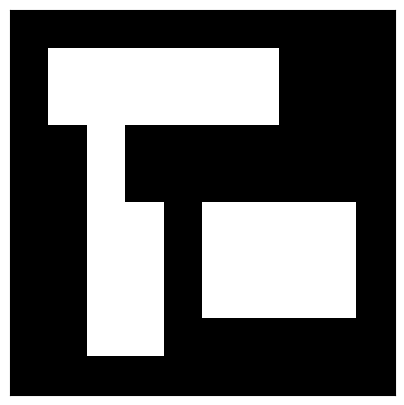

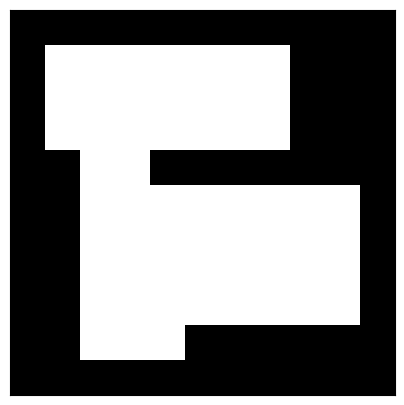

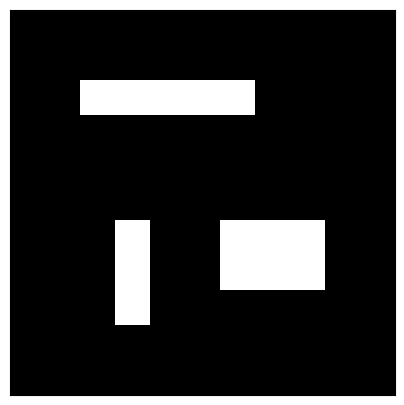

In [ ]:
struct = np.ones((2, 2),np.uint8)

h_color(img_bin, fx=0.5, fy=0.5)
h_color(dilate(img_bin, struct), fx=0.5, fy=0.5)
h_color(erode(img_bin, struct), fx=0.5, fy=0.5)

### Otwarcie i Zamknięcie

Intuicją stojącą za operacją otwarcia jest próba rozłączenia od siebie obszarów, które są słabo ze sobą związane. Przez *słabo* można rozumieć szum lub zwyczajne artefakty powstałe podczas przetwarzania obrazów.

Zastosowanie operacji otwarcia można znaleźć w sytuacji, w której wykonujemy segmentację obiektów i w rezultacie otrzymamy dwa obiekty tej samej klasy obok siebie. Obiekty te mogą być połączone pojedynczymi pikselami. Aby oddzielić te obiekty od siebie (w celu tzw. **instance segmentation**) można skorzystać właśnie z **otwarcia** morfologicznego.

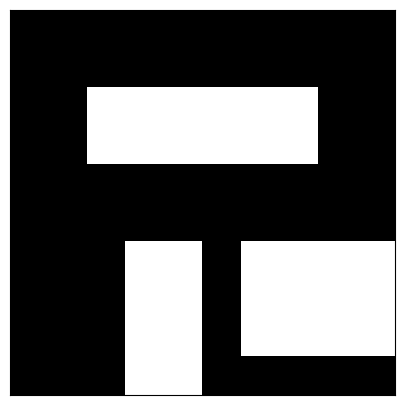

In [ ]:
img_bin_ero = cv2.erode(img_bin, struct, iterations=1)
img_bin_ero_dil = cv2.dilate(img_bin_ero, struct, iterations=1)

h_color(img_bin_ero_dil, fx=0.5, fy=0.5)

Zamierzeniem zamknięcia jest połączenie obszarów znajdujących się blisko siebie ale ze względu na szum/artefakty rozłączne. W poniższym przykładnie oba obszary znajdują się blisko siebie, przez co możliwe, że reprezentują ten sam obiekt. Operacja zamknięcia spowoduje połączenie tych obszarów.

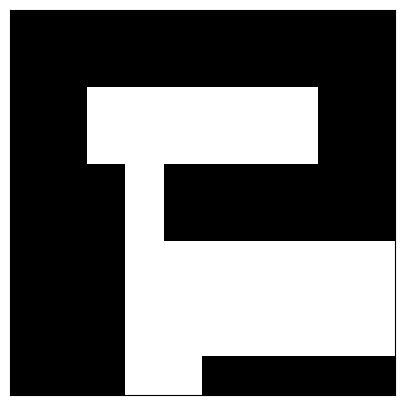

In [ ]:
img_bin_dil = cv2.dilate(img_bin, struct, iterations = 1)
img_bin_dil_ero = cv2.erode(img_bin_dil, struct, iterations = 1)

h_color(img_bin_dil_ero, fx=0.5, fy=0.5)

#### Zadanie 2

Zaimplementuj, korzystając z wcześniej zaimplementowanych operacji erozji i dylatacji, operację otwarcia i zamknięcia zgodnie z poniższymi wzorami:

* $O(f) = {\text{dylatacja}}({\text{erozja}}(f))$ - otwarcie
* $C(f) = {\text{erozja}}({\text{dylatacja}}(f))$ - zamknięcie

**Uwaga: wewnętrzna erozja i dylatacja wykonana jest z tym samym elementem strukturalnym.**

In [ ]:
def open(image, struct_element):
  return dilate(erode(image, struct_element), struct_element)

def close(image, struct_element):
  return erode(dilate(image, struct_element), struct_element)

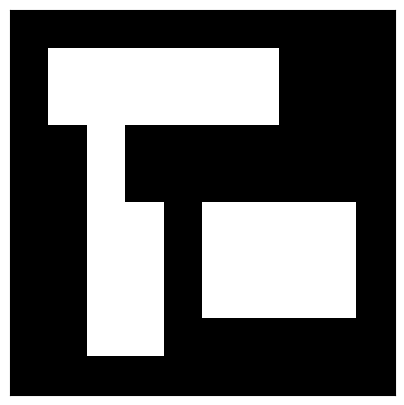

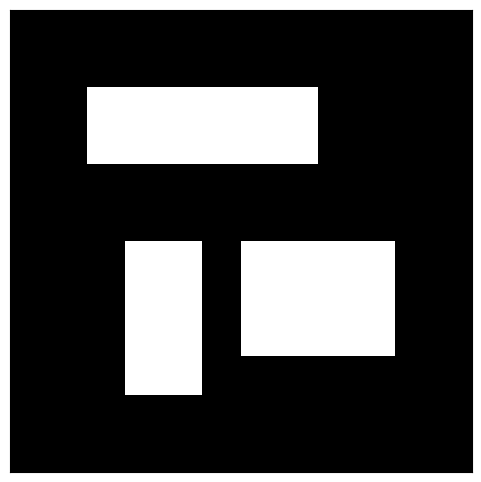

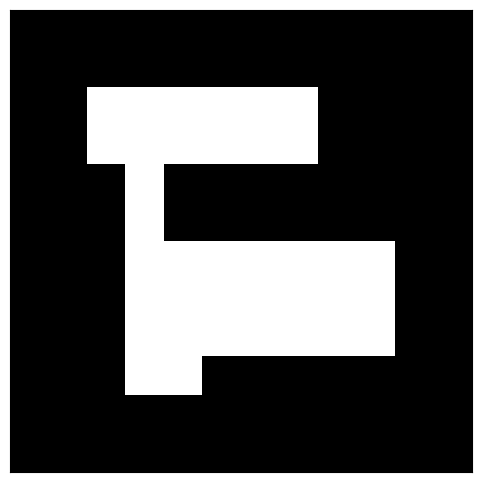

In [ ]:
h_color(img_bin, fx=0.5, fy=0.5)
h_color(open(img_bin, struct), fx=0.5, fy=0.5)
h_color(close(img_bin, struct), fx=0.5, fy=0.5)

### Pozostałe operacje morfologiczne

Istnieje wiele operacji morfologicznych o konkretnych zastosowaniach w przetwarzaniu obrazu. Większość z nich opiera się na operacjach zamknięcia i otwarcia. Oznaczmy otwarcie i zamknięcie jako:

* $O(f) = {\text{dylatacja}}({\text{erozja}}(f))$ - otwarcie
* $C(f) = {\text{erozja}}({\text{dylatacja}}(f))$ - zamknięcie


### Otwarcie właściwe, zamknięcie właściwe i automediana

Dla przytoczonych wyżej definicji otwarcia i zamknięcia, możemy zdefiniować następujące operacje morfologiczne:

* $Q(f) = \min(f, C(O(C(f))))$ - otwarcie właściwe
* $G(f) = \max(f, O(C(O(f))))$ - zamknięcie właściwe
* $A(f) = \max(O(C(O(f))), \min(f, C(O(C(f)))))$ - automediana

Dla poniższego obrazu wykonana zostanie arbitralnie przyjęta binaryzacja, w celu dalszego przetwarzania operacjami morfologicznymi.

Supernowa przedstawiona na obrazie charakteryzuje się wieloma szczegółami w postaci innych galaktyk, które przypominają sztucznie dodany szum. Celem poniższego przetwarzania będzie wykrycie obszarów gdzie znajduje się supernowa, jednocześnie eliminując obszary gdzie znajdują sie obszary nie należące do obiektu.

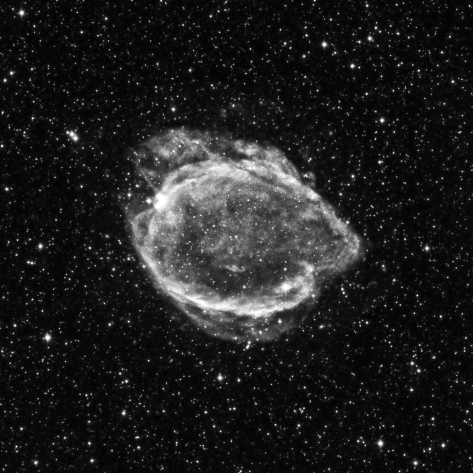

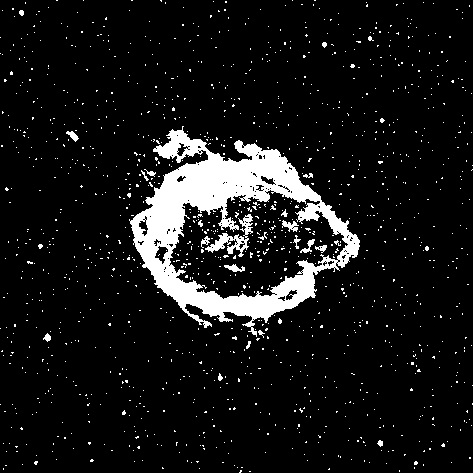

In [ ]:
img_space_raw = cv2.imread('./supernova.jpg', 0)
img_space_raw = cv2.resize(img_space_raw, None, fx=0.5, fy=0.5)
img_space = (img_space_raw > 100).astype(np.uint8) * 255

struct = np.ones([5, 5], np.uint8)
imshow(img_space_raw)
imshow(img_space)

Przypomnijmy, operacja otwarcia właściwego słada się z 3 następujących po sobie operacji: zamknięcia, otwarcia i znowu zamknięcia. Wynik, jest porównywany z **obrazem wejściowym**, a rezultatem jest operacja **min** na obrazie wejściowym i rezultacie sekwencji operacji.

Wynik otwarcia właściwego można zinterpretować jako **wybranie spójnego obszaru z obrazu wejściowego zachowując szczególy znajdujące się na obrazie wejściowym.**


Wyniki pośrednie



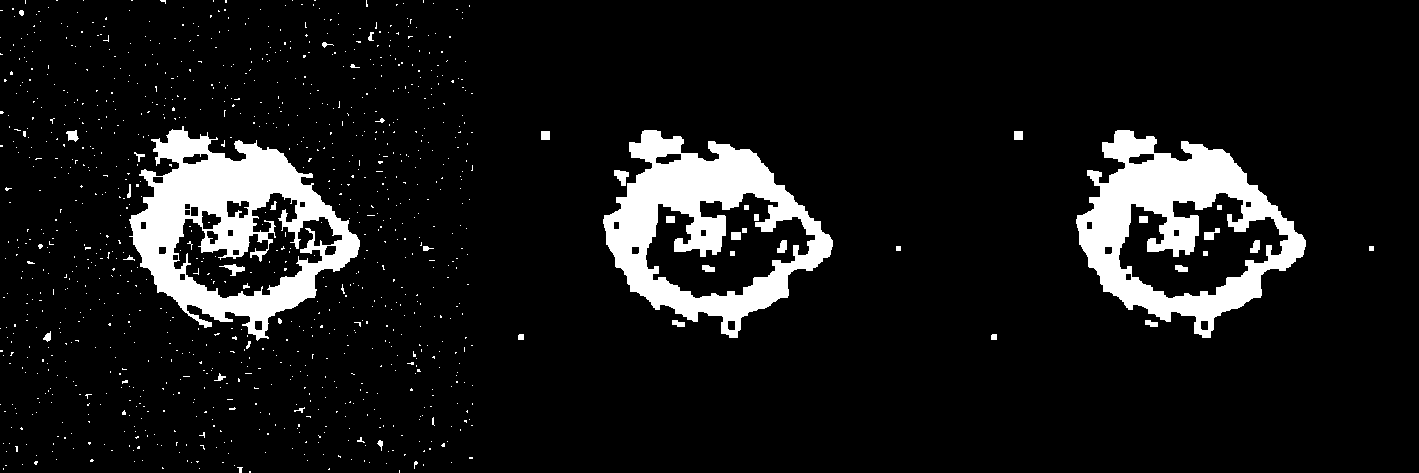


Porównanie obrazu wejściowego i wyniku otwarcia właściwego



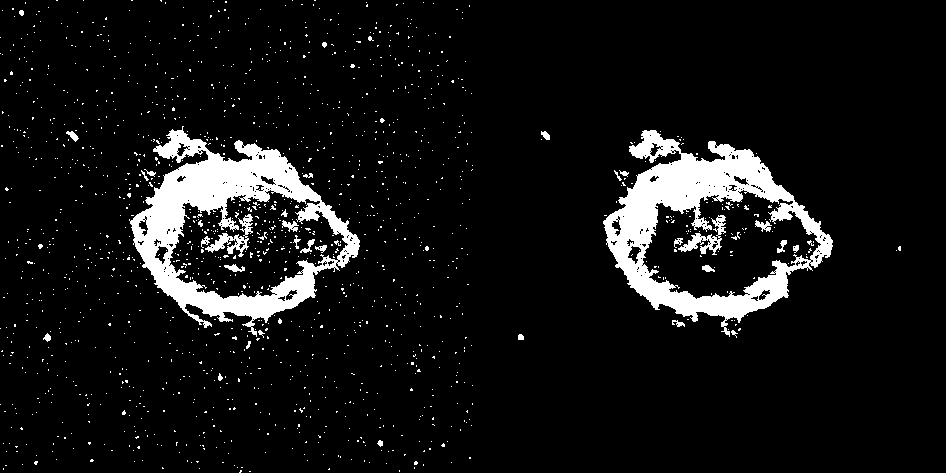

In [ ]:
img_space_close = cv2.morphologyEx(img_space, cv2.MORPH_CLOSE, struct)
img_space_open = cv2.morphologyEx(img_space_close, cv2.MORPH_OPEN, struct)
img_space_close2 = cv2.morphologyEx(img_space_open, cv2.MORPH_CLOSE, struct)
img_space_Q = np.minimum(img_space, img_space_close2)

print('\nWyniki pośrednie\n')
imshow(np.concatenate([img_space_close, img_space_open, img_space_close2], 1))

print('\nPorównanie obrazu wejściowego i wyniku otwarcia właściwego\n')
imshow(np.concatenate([img_space, img_space_Q], 1))

Operacja zamknięcia właściwego składa się z następujących po sobie operacji otwarcia, zamknięcia i znowu otwarcia.

Wyniki można zinterpretować jako obraz wejściowy **z wyszczególnionym obszarem jednolitym**.


Wyniki pośrednie



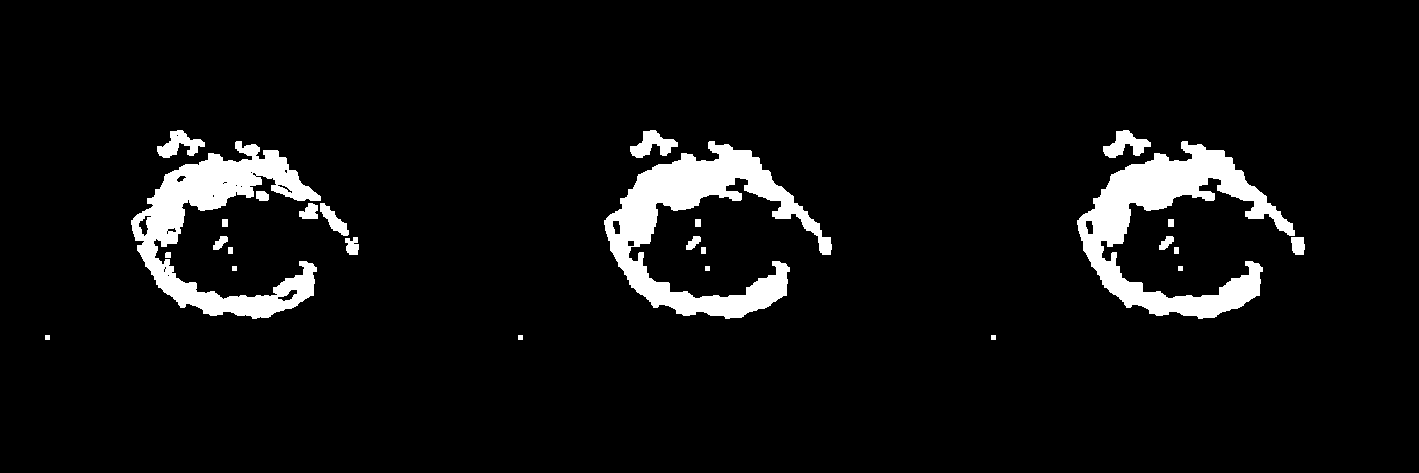


Porównanie obrazu wejściowego i wyniku zamknięcia właściwego



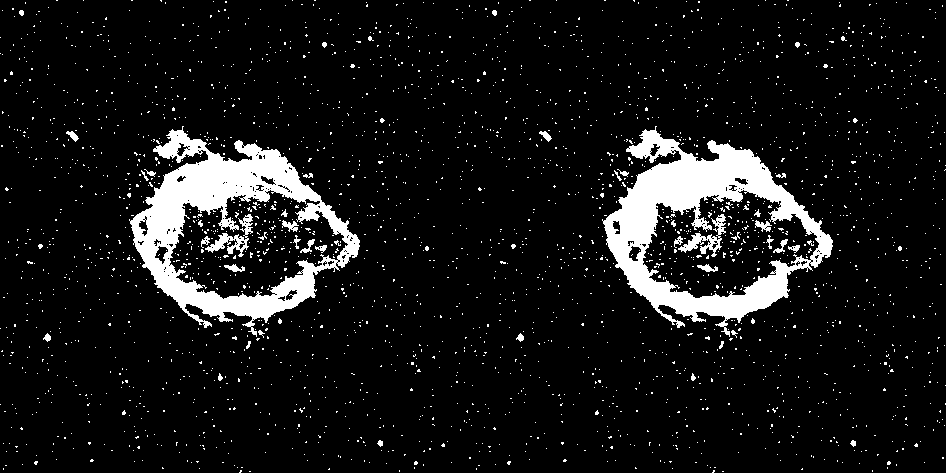

In [ ]:
img_space_open = cv2.morphologyEx(img_space, cv2.MORPH_OPEN, struct)
img_space_close = cv2.morphologyEx(img_space_open, cv2.MORPH_CLOSE, struct)
img_space_open2 = cv2.morphologyEx(img_space_close, cv2.MORPH_OPEN, struct)
img_space_G = np.maximum(img_space, img_space_open2)

print('\nWyniki pośrednie\n')
imshow(np.concatenate([img_space_open, img_space_close, img_space_open2], 1))

print('\nPorównanie obrazu wejściowego i wyniku zamknięcia właściwego\n')
imshow(np.concatenate([img_space, img_space_G], 1))

Dla lepszego porównania wyników poniżej zostały odseparowane obie funkcje $Q$ i $G$, a wyniki zostały skonfrontowane z obrazem wejściowym.

In [ ]:
def Q(img_bin, struct):
  x = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, struct)
  x = cv2.morphologyEx(x, cv2.MORPH_OPEN, struct)
  x = cv2.morphologyEx(x, cv2.MORPH_CLOSE, struct)
  return np.minimum(img_bin, x)

def G(img_bin, struct):
  x = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, struct)
  x = cv2.morphologyEx(x, cv2.MORPH_CLOSE, struct)
  x = cv2.morphologyEx(x, cv2.MORPH_OPEN, struct)
  return np.maximum(img_bin, x)


Porównanie obrazu wejściowego i wyniku otwarcia właściwego



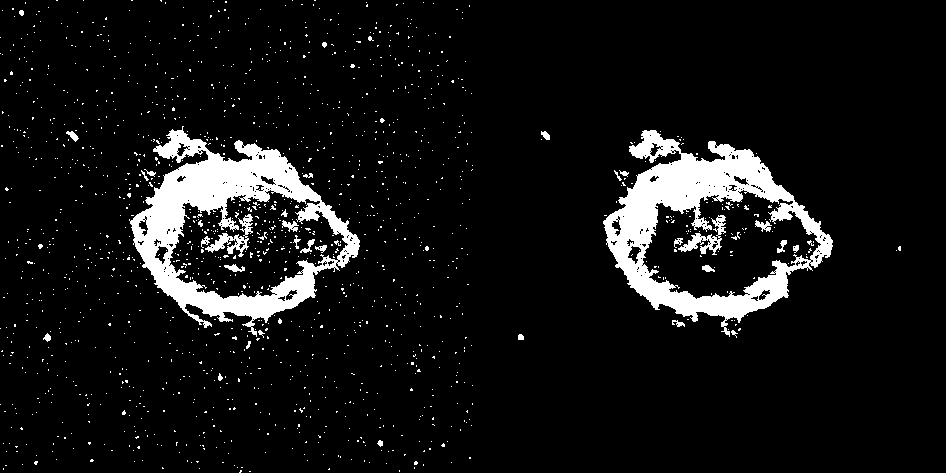


Porównanie obrazu wejściowego i wyniku zamknięcia właściwego



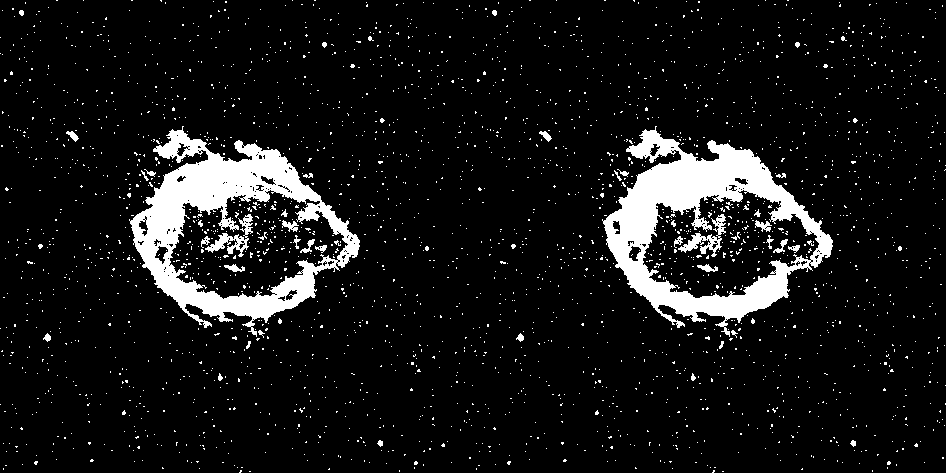

In [ ]:
print('\nPorównanie obrazu wejściowego i wyniku otwarcia właściwego\n')
imshow(np.concatenate([img_space, Q(img_space, struct)], 1))

print('\nPorównanie obrazu wejściowego i wyniku zamknięcia właściwego\n')
imshow(np.concatenate([img_space, G(img_space, struct)], 1))

#### Zadanie 3

Analogicznie do powyższych funkcji, zaimplementuj operację **automediany** i przetestuj ją na wcześniej przetwarzanym obrazie supernowy (w przestrzeni binarnej).

a) skorzystaj z funkcji dostępnych w OpenCV,

b) napisz, czym charakteryzuje się otrzymany obraz w porównaniu z otwarciem właściwym i zamknięciem właściwym.

  - Otrzymany automedianą obraz jest połączeniem właściwości filtracyjnych otwarcia i zamknięcia właściwego. Otwarcie właściwe filtruje jasny szum, a zamknięcie właściwe szum ciemny. Obraz uzyskany z użyciem automediany ma usunięty szum w postaci gwiazd, kontury supernowej podobne jak w przypadku otwarcia właściwego, ale dodatkowo zostaje usunięty ciemny szum występujący w postaci "dziur" na pierścieniu supernowej.


Porównanie obrazu wejściowego i automediany



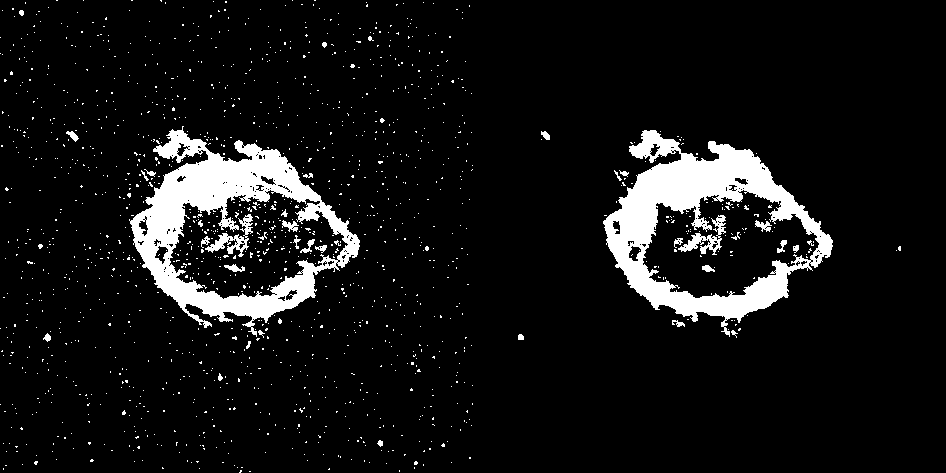

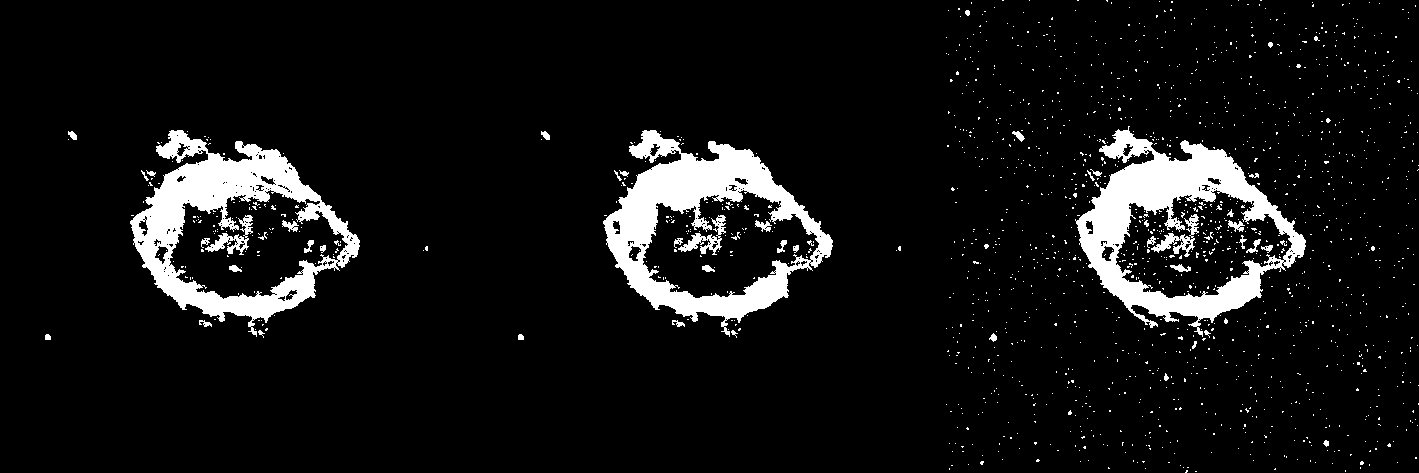

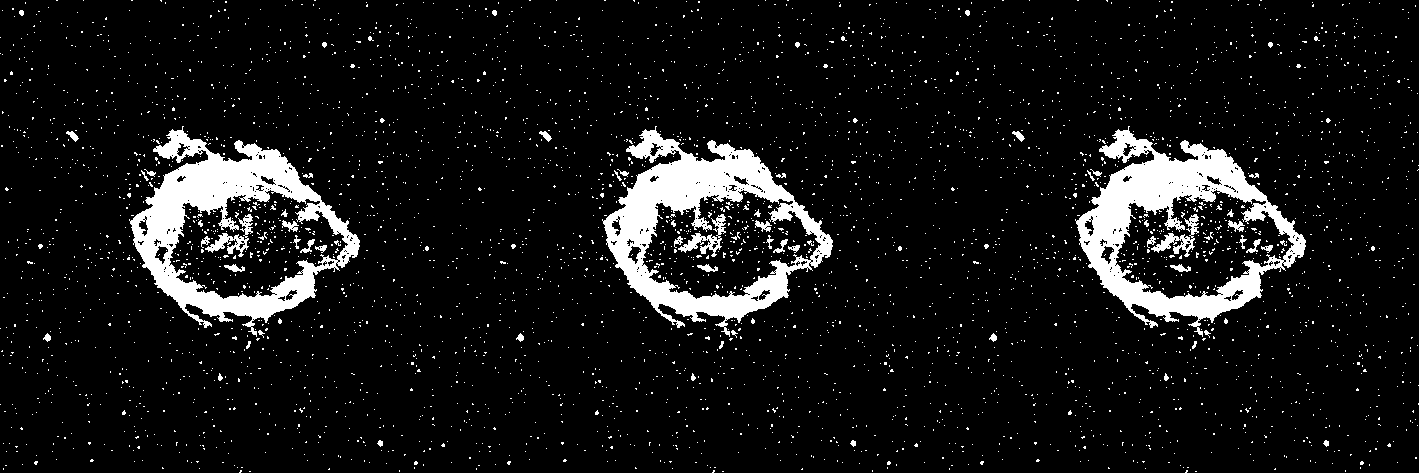

In [ ]:
def A(img_raw, struct):
  img_close_Q = cv2.morphologyEx(img_raw, cv2.MORPH_CLOSE, struct)
  img_open_Q = cv2.morphologyEx(img_close_Q, cv2.MORPH_OPEN, struct)
  img_close2_Q = cv2.morphologyEx(img_open_Q, cv2.MORPH_CLOSE, struct)
  img_Q = np.minimum(img_raw, img_close2_Q)

  img_open_G = cv2.morphologyEx(img_raw, cv2.MORPH_OPEN, struct)
  img_close_G = cv2.morphologyEx(img_open_G, cv2.MORPH_CLOSE, struct)
  img_open2_G = cv2.morphologyEx(img_close_G, cv2.MORPH_OPEN, struct)

  return np.maximum(img_open2_G, img_Q)

print('\nPorównanie obrazu wejściowego i automediany\n')
imshow(np.concatenate([img_space, A(img_space, struct)], 1))
imshow(np.concatenate([Q(img_space, struct), A(img_space, struct), G(img_space, struct)], 1))
imshow(np.concatenate([img_space, img_space,img_space], 1))


## Operacje morfologiczne jako zalążek rozpoznawania wzorców

Operacje morfologiczne są operacjami opartymi na operacjach logicznych. Implikuje to pewne praktyczne zastosowania w przetwarzaniu obrazów, a w szczególności rozpoznawania wzorców.

W ogólności, element strukturalny nie musi być prostym elementem, który sprawia, że wyniki erozji i dylatacji stają się większymi/mniejszymi obszarami. Element strukturalny może przyjąć bardziej złożoną formę i reprezentować pewne poszukiwane cechy na obrazie.

Zdefiniujmy bardziej wyrafinowany obraz binarny, zawierające pewne powtarzające się wzorce.

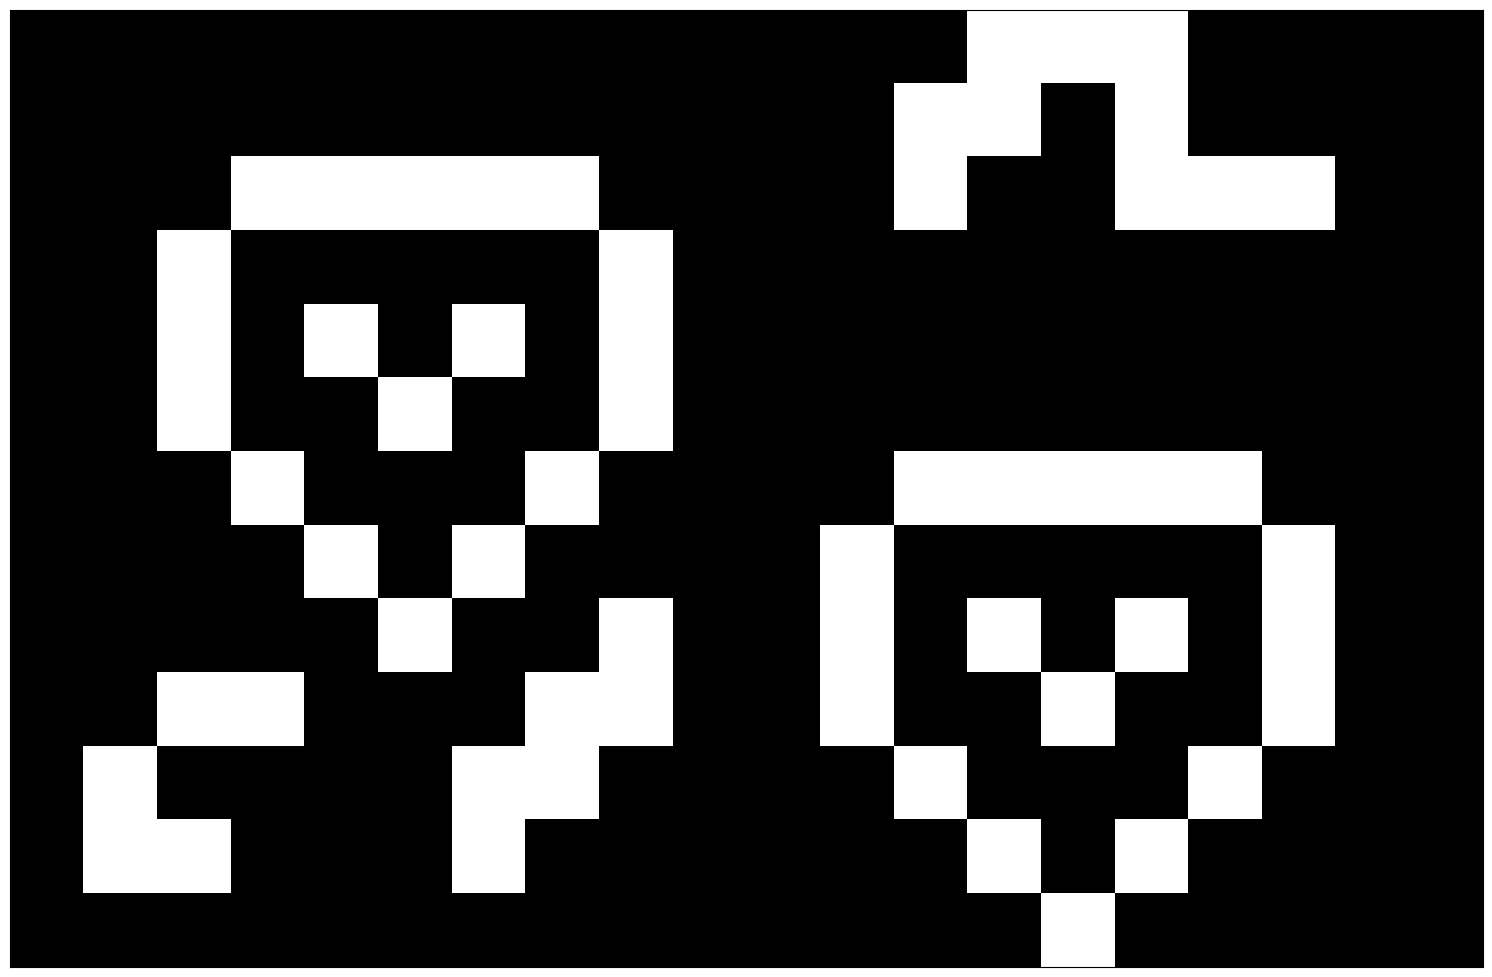

In [ ]:
img_pattern = np.array([
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
  [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0],
  [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
  [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
  [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
  [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
  [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
  [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
], np.uint8)
h_color(img_pattern)

Jako element strukturalny zdefiniujmy sobie właśnie taki wzorzec.

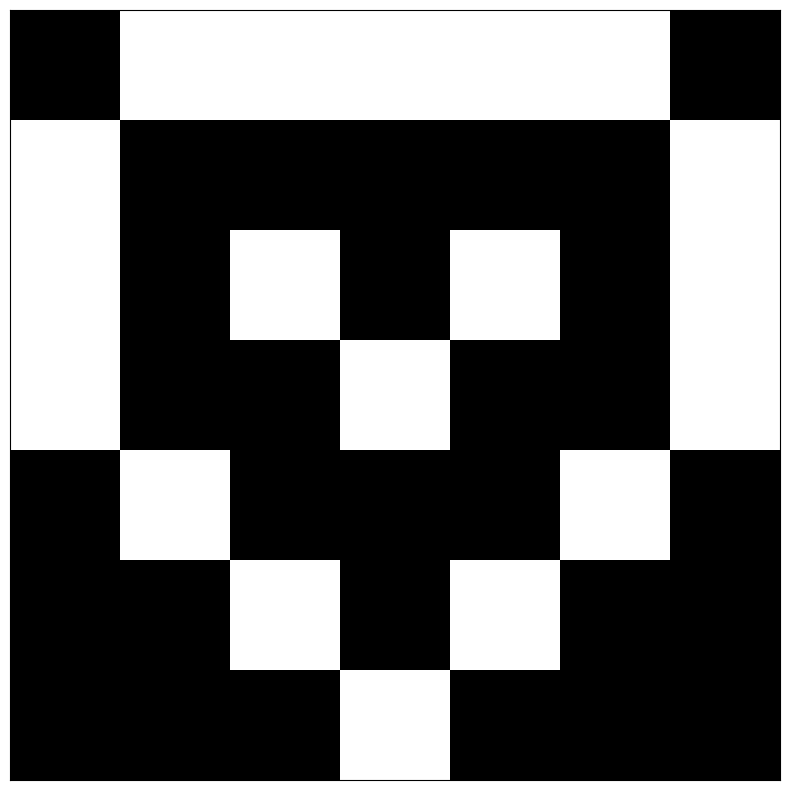

In [ ]:
struct = np.array([
  [0, 1, 1, 1, 1, 1, 0],
  [1, 0, 0, 0, 0, 0, 1],
  [1, 0, 1, 0, 1, 0, 1],
  [1, 0, 0, 1, 0, 0, 1],
  [0, 1, 0, 0, 0, 1, 0],
  [0, 0, 1, 0, 1, 0, 0],
  [0, 0, 0, 1, 0, 0, 0]
], np.uint8)
h_color(struct)

**Spodziewanym rezultatem erozji obrazu wejściowego i obiektu strukturalnego będzie maska bitowa, z zapalonymi pikselami w pozycjach gdzie odnaleziony został obiekt strukturalny.**

(0) obiekt odnaleziony na pozycji (np.int64(5), np.int64(5))
(1) obiekt odnaleziony na pozycji (np.int64(9), np.int64(14))


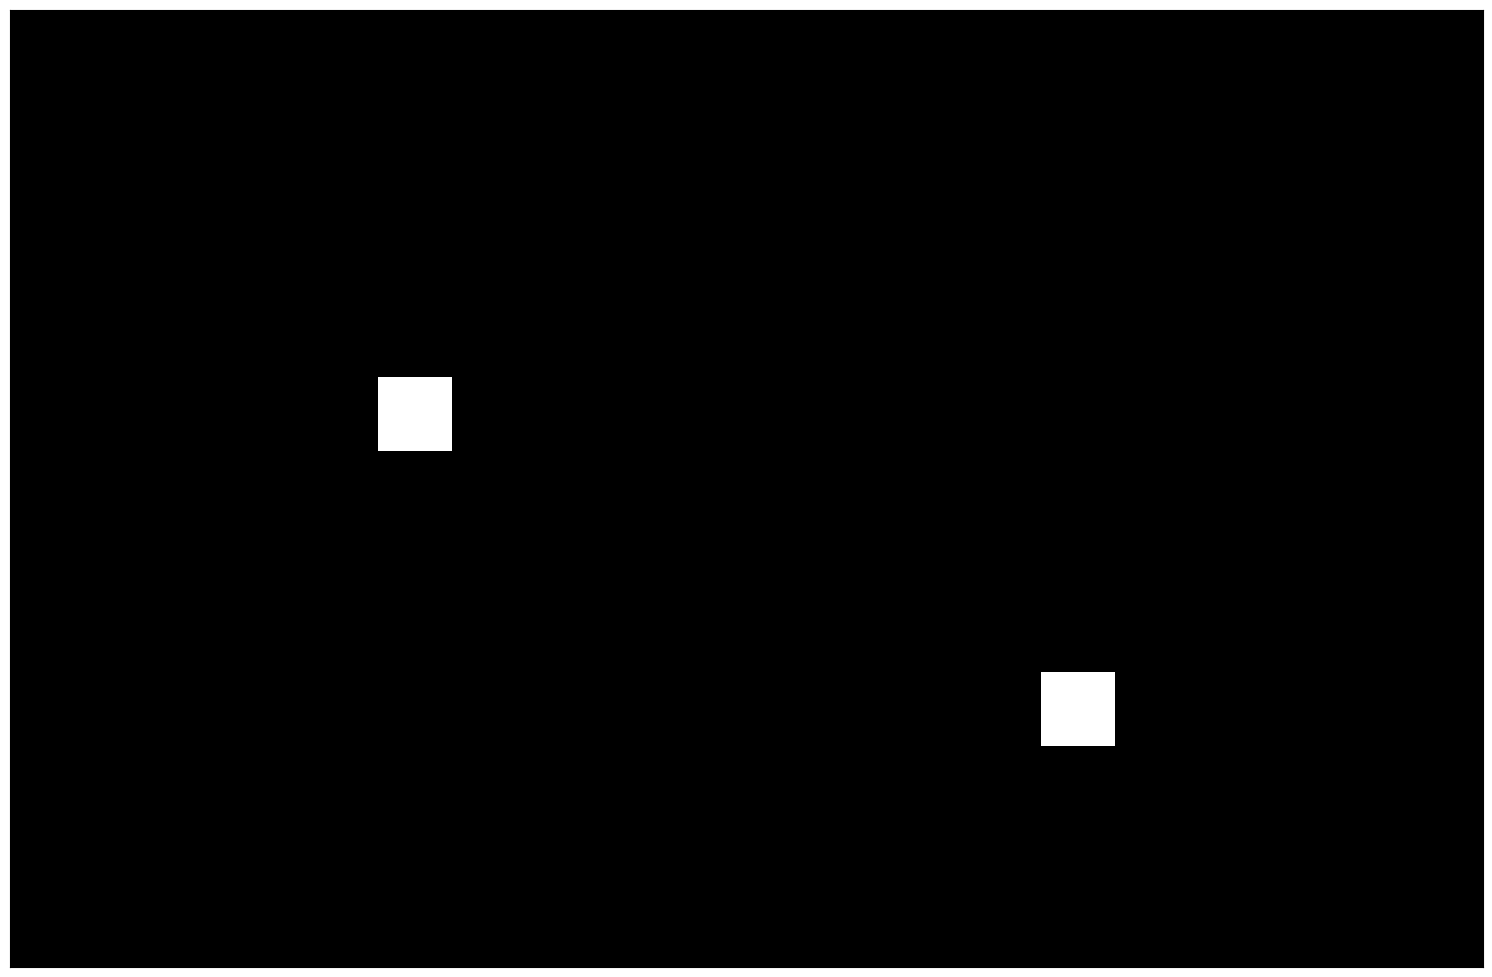

In [ ]:
img_pattern_recognition = cv2.erode(img_pattern, struct, iterations = 1)

for i, xy in enumerate(zip(*np.where(img_pattern_recognition))):
  print(f'({i}) obiekt odnaleziony na pozycji {xy}')

h_color(img_pattern_recognition)

Co więcej, element strukturalny może pochodzić również z samego obrazu - można wyobrazić sobie sytuację w której znajdujemy otoczenia wszystkich pikseli i pobieramy najczęściej pojawiający się element. W ten sposób możemy stworzyć prosty **deskryptor** obrazu i wykorzystać go w przetwarzaniu **innych obrazów**.

## Morfologia ciągła w ujęciu funkcyjnym

Operacje erozji i dylatacji posiadają swoją interpretację w dziedzinie ciągłej. Przeanalizujmy przypadek erozji i dylatacji dla obrazu binarnego, wprowadzony wcześniej na potrzeby zadania 1 (s - element strukturalny, I - obraz wejściowy, d - macierz dopasowania):

$$s = \begin{bmatrix}
0 & 1 & 0\\
1 & -1 & 1\\
-1 & 0 & -1\\
\end{bmatrix}$$

$$I = \begin{bmatrix}
0 & 0 & 0\\
1 & 1 & 1\\
0 & 1 & 0\\
\end{bmatrix}$$

$$d = \begin{bmatrix}
1 & 0 & 1\\
1 & 0 & 1\\
1 & 1 & 1\\
\end{bmatrix}$$

Zdefiniowaliśmy sytuację, w której dylatacja zwróci wartość 1, jako sytuacja w której dowolny element macierzy dopasowania jest równy 1. Aby zaimplementować taką operację można wykonać: $max(d)$, a więc jeśli największa wartość (gdzie dla wartości binarnych wyrażenie $0 < 1$ jest prawdziwe). Widzimy, że operacja $max(d)$ zwróci wartość 1, gdy **dowolny element macierzy d będzie równy 1**.

Analogicznie, erozja zwróci wartość 1, gdy wszystkie elementy macierzy d będą równe 1. Innymi słowy, erozja wykonuje operację $min(d)$.

Dla tak zdefiniowanych operacji możemy wprowadzić erozje i dylatacje w ujęciu funkcyjnym dla dziedziny ciągłej jako:

$$(I \oplus s)(x, y) = \max\{I(x - \Delta x, y - \Delta y) + s(x, y) : (x - \Delta x, y - \Delta y) \in D_I, (x, y) \in D_s\}$$

$$(I \ominus s)(x, y) = \min\{I(x - \Delta x, y - \Delta y) - s(x, y) : (x - \Delta x, y - \Delta y) \in D_I, (x, y) \in D_s\}$$

gdzie:
* $\oplus$ - dylatacja,
* $\ominus$ - erozja,
* $D_I$ - dziedzina obrazu (tj. wszystkie piksele, jeśli piksel nie należy do $D_I$ oznacza to, że wychodzi poza obszar obrazu),
* $D_s$ - dziedzina elementu strukturalnego,
* $\Delta x \Delta y$ - przesunięcia które realizują operację przyłożenia elementu strukturalnego do obrazu,

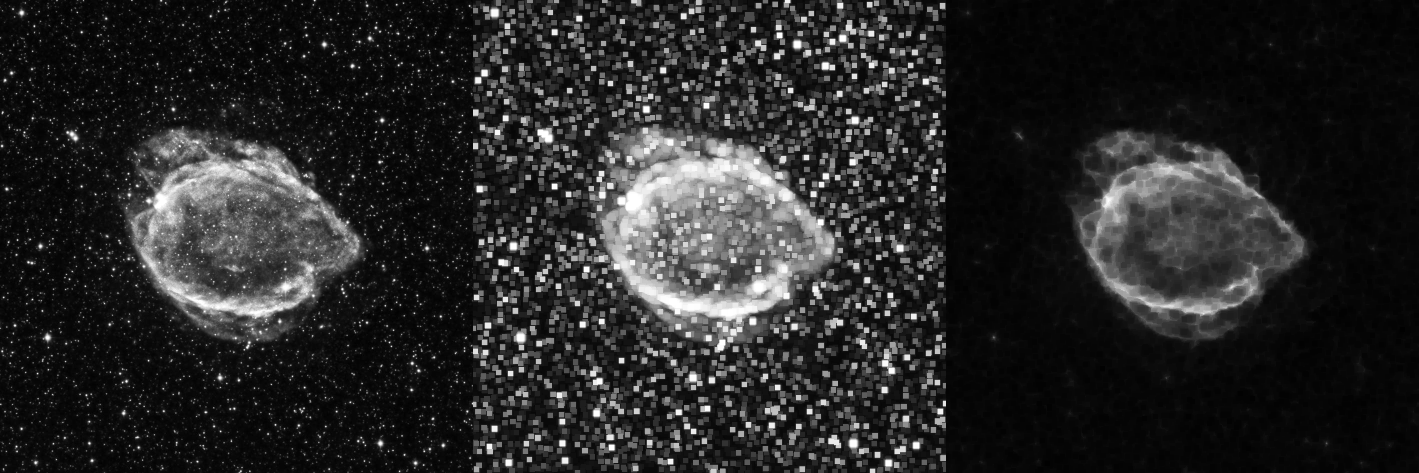

In [ ]:
img_space_raw = cv2.imread('./supernova.jpg', 0)
img_space_raw = cv2.resize(img_space_raw, None, fx=0.5, fy=0.5)

struct = np.ones([5, 5], np.uint8)

img_space_dil = cv2.dilate(img_space_raw, struct, iterations=1)
img_space_ero = cv2.erode(img_space_raw, struct, iterations=1)

imshow(np.concatenate([img_space_raw, img_space_dil, img_space_ero], 1))

### Zadanie 4

Sprawdź, czy implementacja erozji i dylatacji, z zadania 1, działa dla obrazów z dziedziny grayscale. Jeśli nie, zaimplementuj wersję, która obsłuży dane wejściowe w formacie grayscale.

**Uwaga 1: implementacja nie musi obsługiwać wariantu, gdy składową elementu strukturalnego jest wartość -1. Dla uproszczenia można założyć, że element strukturalny zawiera dane jedynie dodatne.**


Wynik operacji morfologicznych dla elementu strukturalnego binarnego



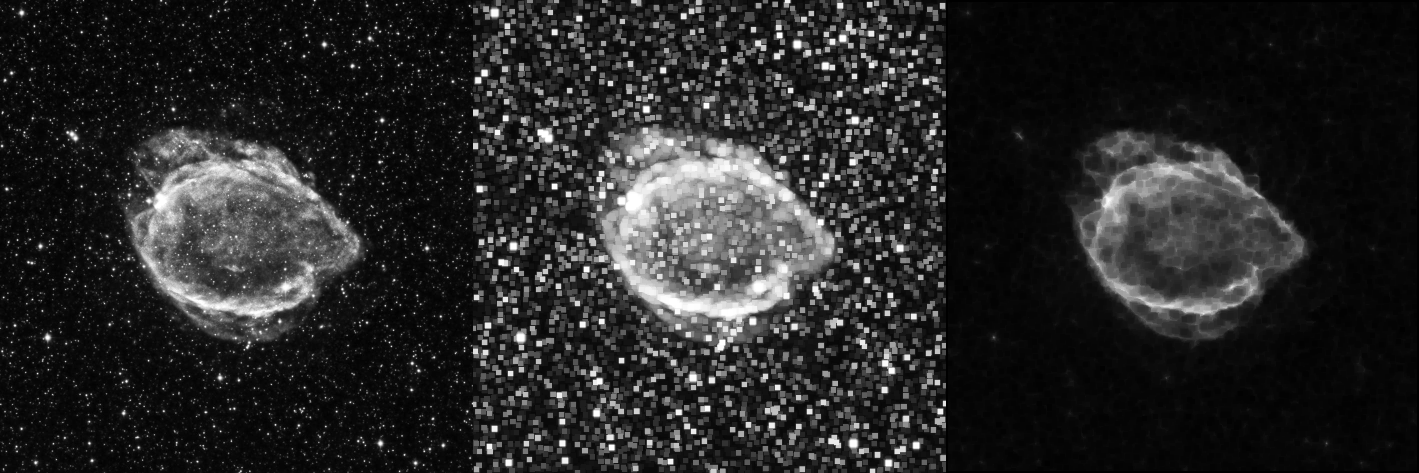


Wynik operacji morfologicznych dla elementu strukturalnego zmiennoprzecinkowego



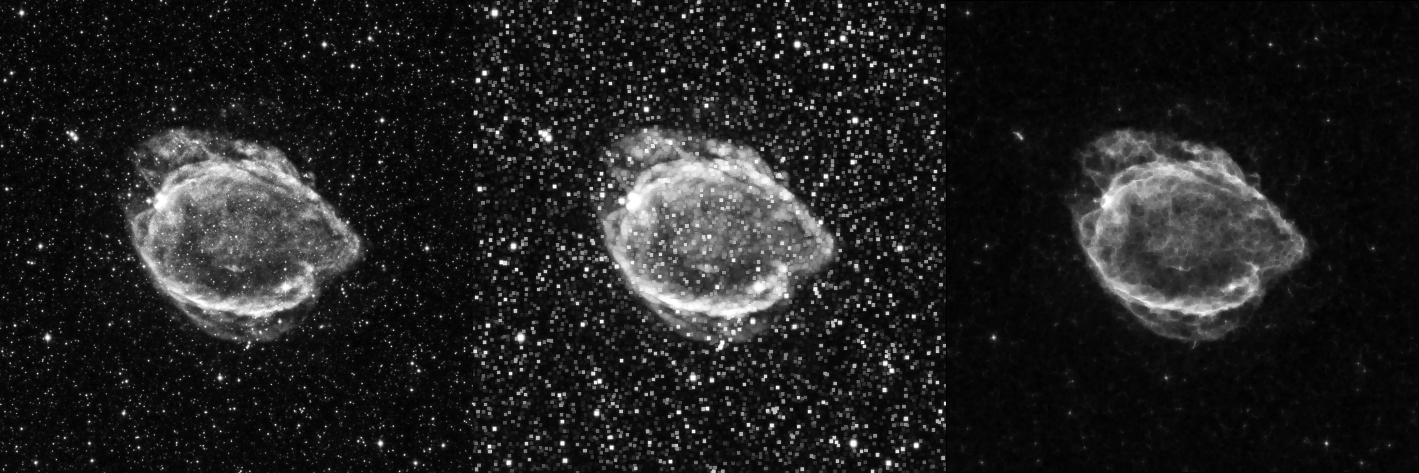

In [ ]:
img_space_raw = cv2.imread('./supernova.jpg', 0)
img_space_raw = cv2.resize(img_space_raw, None, fx=0.5, fy=0.5)

struct_bin = np.ones([5, 5], np.uint8)
struct_float = np.array([
  [0.1, 0.5, 0.1],
  [0.5, 0.8, 0.5],
  [0.1, 0.5, 0.1]
])

# def erode(image, struct_element):
#     h, w = struct_element.shape
#     pad_h, pad_w = h // 2, w // 2
#     padded_img = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)))

#     windows = sliding_window_view(padded_img, (h, w))  # shape: (H, W, h, w)

#     mask = struct_element != -1
#     se_values = struct_element[mask]
#     result = np.all(windows[:, :, mask] == se_values, axis=-1)

#     return result.astype(np.uint8)


def erode_f(image, struct_element):
    h, w = struct_element.shape
    pad_h, pad_w = h // 2, w // 2
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)))

    windows = sliding_window_view(padded, (h, w))

    mask = struct_element != -1
    windows_masked = windows[:, :, mask]

    eroded = np.min(windows_masked, axis=-1)

    return eroded.astype(image.dtype)


def dilate_f(image, struct_element):
    h, w = struct_element.shape
    pad_h, pad_w = h // 2, w // 2
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)))

    windows = sliding_window_view(padded, (h, w))

    mask = struct_element != -1
    windows_masked = windows[:, :, mask]

    dilated = np.max(windows_masked, axis=-1)

    return dilated.astype(image.dtype)


img_space_dil_bin = dilate_f(img_space_raw, struct_bin)
img_space_ero_bin = erode_f(img_space_raw, struct_bin)
img_space_dil_float = dilate_f(img_space_raw, struct_float)
img_space_ero_float = erode_f(img_space_raw, struct_float)

print('\nWynik operacji morfologicznych dla elementu strukturalnego binarnego\n')
imshow(np.concatenate([img_space_raw, img_space_dil_bin, img_space_ero_bin], 1))

print('\nWynik operacji morfologicznych dla elementu strukturalnego zmiennoprzecinkowego\n')
imshow(np.concatenate([img_space_raw, img_space_dil_float, img_space_ero_float], 1))

## Zadanie Dodatkowe 5\*

Zaimplementuj algorytm wykrywania krawędzi dla obrazów binarnych oparty na operacji ścieniania (**thinning**).

[Link do wikipedii](https://pl.wikipedia.org/wiki/Cyfrowe_przetwarzanie_obraz%C3%B3w_binarnych)

**Uwaga: nie wykorzystuj OpenCV do wykonywania operacji morfoologicznych.**

In [ ]:
img_bin = np.array([
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0],
  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0],
  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0],
  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
  [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
], np.uint8)

struct = np.ones([3, 3], np.uint8)

# TODO:
img_thin = ...
raise NotImplementedError()

h_color(img_bin, fx=1.0, fy=1.0)
h_color(img_thin, fx=1.0, fy=1.0)


NotImplementedError: 